# Classification d'image

Après avoir tester la faisabilité de classification avec le texte et les images nous avons conclus que la classification avec les images est plus éfficace. 

Nous allons ici tester notre model de classification.

# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.image import imread
import re
import time

from wordcloud import WordCloud

import nltk

from collections import defaultdict, Counter

from sklearn import manifold, cluster, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.optimize import linear_sum_assignment

import tensorflow as tf
import tensorflow.keras
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications import MobileNet
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet import preprocess_input
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.applications import MobileNetV2

import glob

from datasets import Dataset

from PIL import Image, ImageEnhance

import cv2

import locale
import os #intéragir avec le système d'exploitation
import zipfile #lecture et écriture pour les fichiers zip
import urllib #gestion des url
import sqlite3
import sys
import os

# Obtenir le répertoire de travail courant (répertoire du notebook)
current_dir = os.getcwd()

# Chemin relatif vers le répertoire contenant fonctions.py
relative_path = 'Openclassrooms'

# Chemin absolu vers le répertoire contenant fonctions.py
absolute_path = os.path.join(current_dir, relative_path)

# Insérer le chemin relatif dans sys.path
sys.path.insert(1, absolute_path)

# Importer les fonctions depuis fonctions.py
from fonctions import data_information, doublons

In [2]:
data = pd.read_csv('data_projet6.csv')

In [3]:
display(data_information(data))

Nombre de ligne : 1050 Nombre de colonne : 23
------
Types des variables :
object     19
float64     2
bool        1
int64       1
dtype: int64
------
% de valeurs manquantes par colonne : 


cat_product_7              0.945714
cat_product_6              0.879048
cat_product_5              0.614286
cat_product_4              0.353333
brand                      0.321905
cat_product_3              0.002857
retail_price               0.000952
discounted_price           0.000952
product_specifications     0.000952
cat_product_2              0.000000
cat_product_1              0.000000
category_count             0.000000
uniq_id                    0.000000
overall_rating             0.000000
crawl_timestamp            0.000000
description                0.000000
is_FK_Advantage_product    0.000000
image                      0.000000
pid                        0.000000
product_category_tree      0.000000
product_name               0.000000
product_url                0.000000
product_rating             0.000000
dtype: float64

None

In [4]:
# Chemin du dossier contenant les images
image_folder = './Flipkart/images'

In [5]:
image_path = glob.glob(image_folder + '*/*.jp*')

# Fonctions

In [6]:
def create_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
def train_model(model, augmentation_config, train_df, test_df, batch_size=32, epochs=10):

    datagen = ImageDataGenerator(**augmentation_config, rescale=1./255)
    
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=test_df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Configurer EarlyStopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Entraîner le modèle
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator) // batch_size,
        validation_data=test_generator,
        validation_steps=len(test_generator) // batch_size,
        epochs=epochs,  
        callbacks=[early_stopping]
    )

    return model, history

In [8]:
def evaluate_model(model, test_df, batch_size=32):
    # Préparer le générateur de données de test
    test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=test_df,
        x_col='image_path',
        y_col='label',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Évaluer le modèle
    test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
    
    # Prédictions
    test_generator.reset()
    predictions = model.predict(test_generator, steps=len(test_generator))
    print('Predictions shape:', predictions.shape)
    
    # Convertir les prédictions en classes
    predicted_classes = np.argmax(predictions, axis=1)
    print('Predicted classes shape:', predicted_classes.shape)

    # Calculer les classes vraies
    true_classes = np.array(test_generator.classes)
    print('True classes shape:', true_classes.shape)

    # Vérifier la cohérence des tailles
    if len(true_classes) != len(predicted_classes):
        raise ValueError(f"Le nombre d'échantillons dans true_classes ({len(true_classes)}) ne correspond pas au nombre d'échantillons dans predicted_classes ({len(predicted_classes)})")

    # Calculer les métriques
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')

    return test_accuracy, precision, recall

In [9]:
def conf_mat_transform(y_true, y_pred, test_generator, ax):
    """
    Transforme les étiquettes prédites pour correspondre aux vraies catégories
    en maximisant les valeurs sur la diagonale de la matrice de confusion.

    Args:
    - y_true: Étiquettes réelles
    - y_pred: Étiquettes prédites
    - test_generator: Le générateur utilisé pour obtenir les noms des classes
    - ax: L'axe matplotlib sur lequel tracer la matrice de confusion
    """

# Calcul de la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    print("Matrice de confusion originale:\n", conf_mat)
    
    # Création de la matrice de coût pour trouver la meilleure correspondance
    cost_matrix = -conf_mat  # On maximise sur la diagonale en minimisant le coût
    
    # Trouver la meilleure permutation des colonnes pour maximiser les valeurs sur la diagonale
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Réordonner les colonnes de la matrice de confusion en fonction de la meilleure permutation
    conf_mat_transformed = conf_mat[:, col_ind]
    print("Matrice de confusion transformée:\n", conf_mat_transformed)
    
    # Réordonner les labels (clusters) en fonction de la meilleure permutation
    reordered_cluster_labels = [col_ind[i] for i in range(len(col_ind))]
    
    # Créer un mappage entre les clusters et les vraies catégories
    cluster_to_category = {i: col_ind[i] for i in range(len(col_ind))}
    
    # Transformer les étiquettes prédites pour qu'elles correspondent aux vraies catégories
    y_pred_transform = np.array([cluster_to_category[cluster] for cluster in y_pred])
    
    # Obtenir les noms des classes
    class_labels = list(test_generator.class_indices.keys())
    
    # Création d'un DataFrame pour une meilleure visualisation
    df_cm = pd.DataFrame(conf_mat_transformed, index=class_labels, columns=reordered_cluster_labels)

    # Afficher la matrice de confusion avec les vrais noms des catégories (Y) et les labels encodés (X)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", 
                yticklabels=class_labels, xticklabels=range(len(class_labels)), ax=ax)

    # Ajouter les titres et les labels
    ax.set_xlabel('Prédictions (Labels encodés)')
    ax.set_ylabel('Vérités terrain (Noms des catégories)')
    ax.set_title('Matrice de confusion')

    # Afficher la figure
    plt.show()
    
    return y_pred_transform, df_cm

# Préparation des données

Nous avons maintenant un modèle compilé et pret à être tester sur nos données. 

Avant cela nous allons préparer nos données pour qu'elles puissent passer dans notre modèle. 
- Encoder la variable catégorie
- Création d'un df avec uniquement les 2 variables necessaires :
    - chemin des images qui servent d'identification aux images et permettrons de faire des visualisations
    - les catégories associées aux images

In [10]:
display(data.head())

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category_count,cat_product_1,cat_product_2,cat_product_3,cat_product_4,cat_product_5,cat_product_6,cat_product_7
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",4,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...,NaN,NaN,NaN
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",5,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...",NaN,NaN
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",5,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE ...,NaN,NaN
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",5,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King size...,NaN,NaN
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",5,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double B...,NaN,NaN


In [11]:
image_paths = [os.path.join(image_folder, img) for img in data['image']]
categories = data['cat_product_1'].values

# Encoder les catégories
y = pd.get_dummies(data['cat_product_1']).values

In [12]:
# Create a DataFrame with image paths and labels
df = pd.DataFrame({'image_path': image_paths, 'label': categories})

display(df.head())
print(df.shape)

,image_path,label
0,./Flipkart/images/55b85ea15a1536d46b7190ad6fff...,Home Furnishing
1,./Flipkart/images/7b72c92c2f6c40268628ec5f14c6...,Baby Care
2,./Flipkart/images/64d5d4a258243731dc7bbb1eef49...,Baby Care
3,./Flipkart/images/d4684dcdc759dd9cdf41504698d7...,Home Furnishing
4,./Flipkart/images/6325b6870c54cd47be6ebfbffa62...,Home Furnishing


(1050, 2)


In [13]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

## Metriques

Afin de comparer les modeles nous avons sélectionnés 3 metriques adaptés à notre projet :
- **accuracy** (la distribution des produits par catégorie est homogène)
- **precison**
- **recall**

Plus d'information sur ces [metriques](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall?hl=fr).

In [14]:
# Pour les metriques

# Nombre fixe de classes
num_classes = 7

# Préparer le DataFrame pour les résultats
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])

In [15]:
# Augmentation de la limite de la taille des images en pixel
Image.MAX_IMAGE_PIXELS = 93680328 

In [16]:
class PyDataset(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)  # Correctly call parent constructor
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Test classification



## Debug

In [17]:
def verify_generator(generator):
    # Étape 1: Vérifiez la forme des données produites par le générateur
    for x_batch, y_batch in generator:
        print("Forme du batch d'images (X):", x_batch.shape)
        print("Forme du batch d'étiquettes (Y):", y_batch.shape)
        break  # On vérifie seulement le premier lot pour le débogage

    # Étape 2: Vérifiez le mapping entre les images et les étiquettes
    for x_batch, y_batch in generator:
        for i in range(5):  # Afficher les 5 premières images du lot
            plt.imshow(x_batch[i])
            plt.title(f"Étiquette: {np.argmax(y_batch[i])}")
            plt.show()
        break

    # Étape 3: Vérifiez les classes et les labels
    print("Classes uniques dans le DataFrame d'entraînement:", generator.class_indices)
    class_counts = pd.Series(generator.classes).value_counts()
    print("Nombre d'images par classe dans le générateur d'entraînement:")
    print(class_counts)

    # Étape 4: Vérifiez le batch_size et steps_per_epoch
    batch_size = generator.batch_size
    print("Batch size:", batch_size)
    num_images = len(generator.filenames)
    steps_per_epoch = num_images // batch_size
    print("Steps per epoch:", steps_per_epoch)

    # Étape 5: Exécutez un lot manuellement pour vérifier la cohérence
    x_batch, y_batch = next(generator)
    print("Exécution d'un batch pour vérification :")
    print(f"Images shape: {x_batch.shape}, Labels shape: {y_batch.shape}")

**Repasser cette cellule en 'code' pour debug**

batch_size=32
#Création des générateurs de données
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

#Vérification des générateurs
print("Vérification du générateur d'entraînement:")
verify_generator(train_generator)

print("Vérification du générateur de test:")
verify_generator(test_generator)

In [18]:
def visualize_batches(generator, num_batches=1):
    for i in range(num_batches):
        x_batch, y_batch = next(generator)
        plt.figure(figsize=(10, 10))
        for j in range(9):  # Afficher 9 images par batch
            plt.subplot(3, 3, j+1)
            plt.imshow(x_batch[j])
            plt.title(f"Label: {np.argmax(y_batch[j])}")
            plt.axis('off')
        plt.show()

#print("Visualisation des batches d'entraînement:")
#visualize_batches(train_generator)

#print("Visualisation des batches de test:")
#visualize_batches(test_generator)

## Entrainement des modeles

In [19]:
# Modèle de base sans augmentation
base_model = create_model(num_classes)

In [20]:
trained_base_model, base_training_history = train_model(base_model, {}, train_df, test_df)

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.4973 - loss: 1.4868 - val_accuracy: 0.3524 - val_loss: 7.6453
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8236 - loss: 0.5041 - val_accuracy: 0.3381 - val_loss: 8.4531
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8616 - loss: 0.4527 - val_accuracy: 0.3667 - val_loss: 6.5136
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8400 - loss: 0.4765 - val_accuracy: 0.3190 - val_loss: 9.3479
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9161 - loss: 0.3080 - val_accuracy: 0.2905 - val_loss: 6.6507
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8746 - loss: 0.4228 - val_accuracy: 0.3619 - val_loss: 12.2799
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9077 - loss: 0.3116 - val_accuracy: 0.2048 - val_loss: 13.0233
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9106 - loss: 0.2693 - val_accuracy: 0.2524 - val_loss: 13.3386


In [21]:
base_accuracy, base_precision, base_recall = evaluate_model(trained_base_model, test_df)

Found 210 validated image filenames belonging to 7 classes.


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 0.3900 - loss: 6.4716
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 577ms/step
Predictions shape: (210, 7)
Predicted classes shape: (210,)
True classes shape: (210,)


In [22]:
# Modèle avec augmentation de données (configuration 1)
augmented_config_1 = {
    'rotation_range': 40,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}
augmented_model_1 = create_model(num_classes)

trained_augmented_model_1, augmented_training_history_1 = train_model(
    augmented_model_1, augmented_config_1, train_df, test_df)

augmented_accuracy_1, augmented_precision_1, augmented_recall_1 = evaluate_model(
    trained_augmented_model_1, test_df)

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4753 - loss: 1.4814 - val_accuracy: 0.4333 - val_loss: 7.8200
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6925 - loss: 0.9044 - val_accuracy: 0.1714 - val_loss: 20.7614
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7462 - loss: 0.7356 - val_accuracy: 0.3048 - val_loss: 9.1323
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.6964 - loss: 0.9715 - val_accuracy: 0.1476 - val_loss: 13.7950
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8212 - loss: 0.6346 - val_accuracy: 0.1476 - val_loss: 17.4012
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7938 - loss: 0.6304 - val_accuracy: 0.1429 - val_loss: 25.4144
Found 210 validated image filenames belonging to 7 classes.


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 561ms/step - accuracy: 0.4531 - loss: 7.0636
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step
Predictions shape: (210, 7)
Predicted classes shape: (210,)
True classes shape: (210,)


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Modèle avec augmentation de données (configuration 2)
augmented_config_2 = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.1,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}
augmented_model_2 = create_model(num_classes)

trained_augmented_model_2, augmented_training_history_2 = train_model(
    augmented_model_2, augmented_config_2, train_df, test_df)

augmented_accuracy_2, augmented_precision_2, augmented_recall_2 = evaluate_model(
    trained_augmented_model_2, test_df)

Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/10


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5375 - loss: 1.4354 - val_accuracy: 0.5286 - val_loss: 4.8949
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7834 - loss: 0.7247 - val_accuracy: 0.3952 - val_loss: 5.5142
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8339 - loss: 0.5405 - val_accuracy: 0.2571 - val_loss: 10.6033
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.8114 - loss: 0.6489 - val_accuracy: 0.3143 - val_loss: 9.9666
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8471 - loss: 0.4400 - val_accuracy: 0.3619 - val_loss: 6.2798
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8187 - loss: 0.5354 - val_accuracy: 0.3381 - val_loss: 10.5312
Found 210 validated image filenames belonging to 7 classes.


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 539ms/step - accuracy: 0.5090 - loss: 5.2735
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step
Predictions shape: (210, 7)
Predicted classes shape: (210,)
True classes shape: (210,)


In [25]:
# Affichage des résultats
metrics_df = pd.DataFrame({
    'Model': ['BaseModel', 'AugmentedModel1', 'AugmentedModel2'],
    'Accuracy': [base_accuracy, augmented_accuracy_1, augmented_accuracy_2],
    'Precision': [base_precision, augmented_precision_1, augmented_precision_2],
    'Recall': [base_recall, augmented_recall_1, augmented_recall_2]
})

print(metrics_df)

             Model  Accuracy  Precision    Recall
0        BaseModel  0.366667   0.738132  0.366667
1  AugmentedModel1  0.433333   0.508523  0.433333
2  AugmentedModel2  0.528571   0.737069  0.528571


**CONCLUSION**

On peut voir dans le tableau d'affichage des métriques que la configuration de data augmentation n°2 est beaucoup plus probante. La configuration testée varie moins que la configuration n°1. On peut donc penser que les transformations d'images sont trop importante pour le modèle.

## Prédiction

In [26]:
# Faire des prédictions sur le jeu de test
test_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Vraies étiquettes
y_true = test_generator.classes

# Prédictions du modèle
y_pred_probs = trained_augmented_model_2.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

Found 210 validated image filenames belonging to 7 classes.


/Users/laurachatard/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step


Matrice de confusion originale:
 [[16  0  3  8  0  0  0]
 [ 0  9  6  6  0  0  0]
 [ 0  0 29  9  0  0  0]
 [ 2  0  2 24  0  0  2]
 [11  0  3 19  2  0  0]
 [ 0  1  9 13  0  3  0]
 [ 0  0  2  3  0  0 28]]
Matrice de confusion transformée:
 [[16  0  3  8  0  0  0]
 [ 0  9  6  6  0  0  0]
 [ 0  0 29  9  0  0  0]
 [ 2  0  2 24  0  0  2]
 [11  0  3 19  2  0  0]
 [ 0  1  9 13  0  3  0]
 [ 0  0  2  3  0  0 28]]


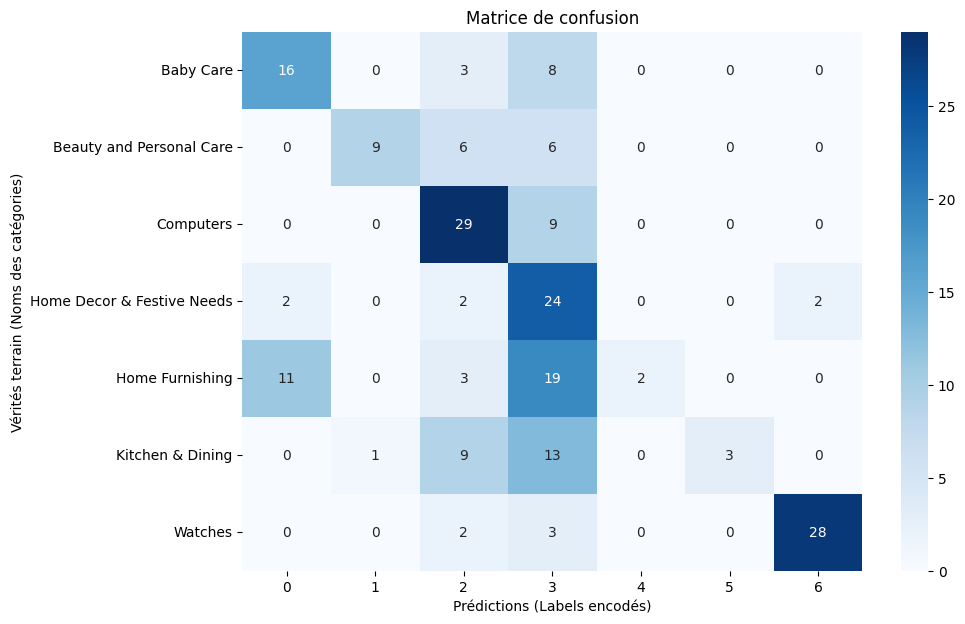

In [27]:
# Utilisation de la fonction pour afficher la matrice de confusion
fig, ax = plt.subplots(figsize=(10, 7))
y_pred_transform, df_cm = conf_mat_transform(y_true, y_pred, test_generator, ax)

# Visualisation des erreurs

In [28]:
# Obtenez le mappage des indices aux noms des catégories
class_indices = test_generator.class_indices
indices_to_labels = {v: k for k, v in class_indices.items()}

# Mappez les indices de y_true aux noms des catégories
true_labels = [indices_to_labels[idx] for idx in y_true]

# Assurez-vous que les prédictions sont des noms de catégories
predicted_labels = y_pred

# Créez un DataFrame à partir de test_df en ajoutant les colonnes de prédictions
predictions_df = test_df.copy()  # Copiez test_df pour conserver l'index et les autres colonnes
predictions_df['predicted_cluster'] = predicted_labels  # Ajoutez les prédictions

# Afficher les premières lignes du DataFrame
display(predictions_df.head())

,image_path,label,predicted_cluster
352,./Flipkart/images/833a87b0af3b84fe246d2ebf271a...,Computers,2
689,./Flipkart/images/55195de3873fffaa9e37b041533d...,Kitchen & Dining,3
485,./Flipkart/images/44b963eb856b4831dfdd21b66659...,Computers,2
388,./Flipkart/images/98ad5b99ad96695568d8f143b11a...,Beauty and Personal Care,1
31,./Flipkart/images/29b1ca231e10d5269516b80bf9d0...,Watches,6


In [29]:
# Créer une table de contingence (matrice de confusion) entre 'true_label' et 'predicted_cluster'
contingency_table = pd.crosstab(predictions_df['label'], predictions_df['predicted_cluster'])

# Ajouter les sommes des lignes
contingency_table.loc['Row Total'] = contingency_table.sum()
# Ajouter les sommes des colonnes
contingency_table['Col Total'] = contingency_table.sum(axis=1)

# Afficher la table de contingence avec les totaux
print("Table de contingence avec les totaux :")
display(contingency_table)

Table de contingence avec les totaux :


predicted_cluster,0,1,2,3,4,5,6,Col Total
label,,,,,,,,
Baby Care,16,0,3,8,0,0,0,27
Beauty and Personal Care,0,9,6,6,0,0,0,21
Computers,0,0,29,9,0,0,0,38
Home Decor & Festive Needs,2,0,2,24,0,0,2,30
Home Furnishing,11,0,3,19,2,0,0,35
Kitchen & Dining,0,1,9,13,0,3,0,26
Watches,0,0,2,3,0,0,28,33
Row Total,29,10,54,82,2,3,30,210


In [32]:
# Filtrer les indices de test_df pour la condition 'Baby Care'
test_indices = predictions_df[predictions_df['label'] == 'Baby Care'].index
print('Indices pour "Baby Care":', len(test_indices))

# Dictionnaire pour stocker les résultats
common_indices_dict = {}

# Parcourir les clusters prédits (0 à 6) pour trouver les correspondances
for i in range(7):
    # Filtrer les indices de predictions_df pour la condition de cluster prédite
    predictions_df_filtered_indices = predictions_df[predictions_df['predicted_cluster'] == i].index

    # Trouver l'intersection des deux ensembles d'indices
    common_indices = test_indices.intersection(predictions_df_filtered_indices)
    
    # Ajouter les résultats au dictionnaire
    common_indices_dict[i] = list(common_indices)

print(common_indices_dict)

Indices pour "Baby Care": 27
{0: [442, 617, 982, 616, 636, 732, 467, 275, 1046, 2, 593, 629, 915, 1001, 449, 622], 1: [], 2: [670, 656, 63], 3: [675, 1048, 428, 784, 789, 615, 66, 106], 4: [], 5: [], 6: []}


442
Cluster 0 - Premier indice: 442
Vérité terrain: Baby Care / Prédiction: 0


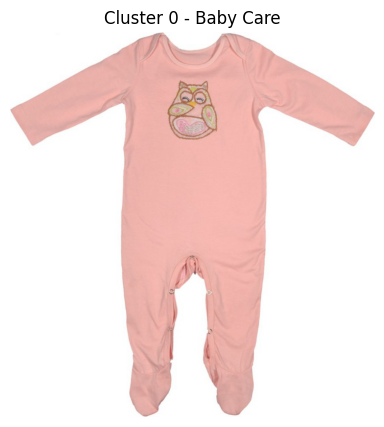

Cluster 1 n'a pas d'indices.
670
Cluster 2 - Premier indice: 670
Vérité terrain: Baby Care / Prédiction: 2


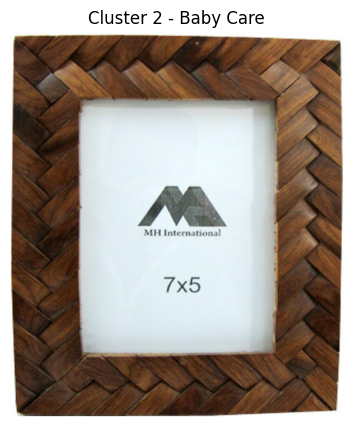

675
Cluster 3 - Premier indice: 675
Vérité terrain: Baby Care / Prédiction: 3


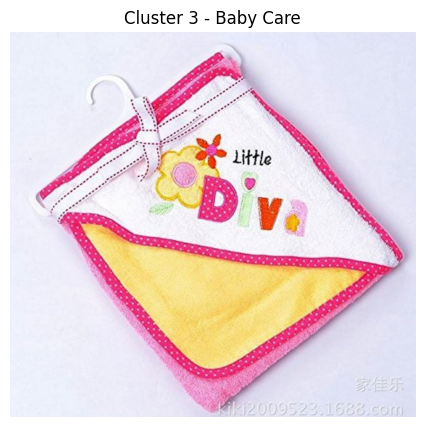

Cluster 4 n'a pas d'indices.
Cluster 5 n'a pas d'indices.
Cluster 6 n'a pas d'indices.


In [33]:
# Parcourir les catégories du dictionnaire
for cluster, indices in common_indices_dict.items():
    if indices:  # Vérifier qu'il y a des indices pour cette catégorie
        first_index = indices[0]  # Obtenir le premier indice
        print(first_index)
        # Trouver le chemin de l'image à partir de predictions_df
        # Obtenir la ligne correspondant à l'index
        row_data = predictions_df.loc[first_index]
        image_path = row_data['image_path']
        true_label = row_data['label']
        predicted_cluster = row_data['predicted_cluster']
        
        print(f"Cluster {cluster} - Premier indice: {first_index}")
        print(f"Vérité terrain: {true_label} / Prédiction: {predicted_cluster}")
        
        # Charger et afficher l'image
        image = imread(image_path)
        plt.figure(figsize=(8, 5))
        plt.imshow(image)
        plt.title(f'Cluster {cluster} - {true_label}')
        plt.axis('off')  # Optionnel: supprimer les axes
        plt.show()
    else:
        print(f"Cluster {cluster} n'a pas d'indices.")

**CONCLUSION**

La matrice de confusion montre que la catégorie Baby Care est plutôt représenté dans le cluster 0, certains éléments de cette catégorie ont été attribué au cluster 2 qui lui est majoritairement représenté par la catégorie Computer. En analysant l'image on peut voir noter plusieurs points qui peuvent être à l'origine de la mauvaise classification : 
- L'image représente à première vue un cadre photo mais d'un point de vue très zoomé on ne discerne pas **les bords de l'objet**
- Il y a au centre de l'image ce que je pense être la dimension du cadre '7x5'. Sans contexte cela peut être une opération mathématique/informatique et donc peut être logiquement attribué à la catégorie Computer.


## Perspective 

Afin d'améliorer la classification des produits, il serai intéressant de tester l'association du texte des descriptions et les images. 